In [1]:
# additional imports of python modules
# python module imports needed in customized functions:
import numpy as np
import tensorflow as tf
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
import pandas as pd
#tf.set_random_seed(1)
#np.random.seed(1)
import sys
tf.__version__, sys.version_info



('1.4.0',
 sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0))

In [2]:
import keras
from keras.utils import np_utils
from keras import backend as K
from keras import metrics


Using TensorFlow backend.


# Import data from keras

In [3]:
from keras.datasets import mnist
#import numpy as np
(x_train, y_train), (x_test, y_test_num) = mnist.load_data()

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test_num, 10)

(60000, 784)
(10000, 784)


# Ladder network: defining the graph


In [5]:
from keras.layers import Input, Dense, GaussianNoise, BatchNormalization, Activation, Layer
from keras.models import Model

stddev = 0.05

## Imports for graph plotting

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

## custom normalization layer
Define a layer that performs normalization (=standardization) of a layer using the mean and the var of the inputs to the layer
The normalization is required before acting with relu:

from https://theneuralperspective.com/2016/10/27/gradient-topics/:

There are several types of normalization techniques but the idea behind all of them is the same, which is shifting our inputs to a zero mean and unit variance. We normalize the inputs before applying the non-linearity. We do this because we do not want the inputs to saturate the non-linearities at the extremes. (Checkout SNNs/SELU for some recent updates on this subject).

Remark about the difference from batch norm:  Batch normalization is very nice but it is based on minibatch size and so it’s a bit difficult to use with recurrent architectures. With layer normalization, we instead compute the mean and variance using ALL of the summed inputs to the neurons in a layer for EVERY single training case. This removes the dependency on a minibatch size. Unlike batch normalization, the normalization operation for layer norm is same for training and inference. More details can be found on Hinton’s paper here.

In [7]:
class CustomLayer_Normalization(Layer):
    """Apply layer normalization.
       shifting our inputs to a zero mean and unit variance. 
       We normalize the inputs before applying the non-linearity. 
       We do this because we do not want the inputs to saturate the non-linearities at the extremes. 
       (Checkout SNNs/SELU for some recent updates on this subject).
       
       no need for build -- no trainable weights. 
        # Arguments
            epsilon: regularizer for zero division
        # Input shape
            Arbitrary. Use the keyword argument `input_shape`
            (tuple of integers, does not include the samples axis)
            when using this layer as the first layer in a model.
        # Output shape
            Same shape as input.
    """
    def __init__(self, epsilon = 1e-6, **kwargs):
        super(CustomLayer_Normalization, self).__init__(**kwargs)
        self.epsilon = epsilon
        
    def call(self, inputs):
        return (inputs - K.mean(inputs,axis=-1,keepdims=True))/(K.std(inputs,axis=-1,keepdims=True)+self.epsilon) # change axis for conv2D
        
    def compute_output_shape(self, input_shape):
        return input_shape
    


## Defining encoder and decoder channels

### Functions that build a generic encoder and decoder layer
Each encoder or decoder layer is composed of sublayers (e.g linear transformation, normalization, activation sublayers). Here we first build the generic structure of the sublayers without defining their input or output dimensions and linking them to each other. In the next step we define the linking functions that specify how the sublayers are connected to each other and what output is delivered. Note that the output of the building functions is sublayers = a dictionary of the (unlinked) sublayers.

In [8]:
def build_encoder_layer(encoding_dim_,layer_id,stddev_=0.05):
    """
    Create the layers
    
    Parameters
    ==========
    
    encoding_dim_:int
        number of perceptons 
    layer_id: string
        part of the name
    stddev: double
        standard deviation of the Gaussion noise layer
        
    Returns
    =======
    
    x,y: I don't know what this is
    
    """
    sublayers={}
    s_id = 'encoder_' + layer_id + '/'
    sublayers['lin_trans'] = Dense(encoding_dim_,activation = None,name=s_id + 'lt')
    sublayers['norm'] = CustomLayer_Normalization(name=s_id + 'norm')
    sublayers['noise_add'] = GaussianNoise(stddev_,name=s_id + 'noise')
    sublayers['batch_norm'] = BatchNormalization(name=s_id + 'bn')
    sublayers['activation'] = Activation('relu',name=s_id + 'output')
    return sublayers

def build_decoder_layer(decoding_dim_,layer_id,activation_name):
    sublayers={}
    s_id = 'decoder' + layer_id + '/'
    sublayers['lin_trans']  = Dense(decoding_dim_,activation = None,name = s_id + 'lt')
    sublayers['norm'] = CustomLayer_Normalization(name=s_id + 'norm')
    sublayers['activation'] = Activation(activation_name,name=s_id + 'output')
    return sublayers

### Functions that link the sublayers within the encoder and the decoder
Here we define functions that specify how the sublayers within each encoder/decoder layer should be linked to each other. Note that the encoder linking functions return two outputs: the final one and an intermediate one that is required for the combinator function of the ladder.

In [9]:
def link_sublayer_corr_encoder(x,sublayers):
    """
    Link the sublayers for the autoencoder
    
    Parameters
    ==========
    x: input for the first sublayer
    
    sublayers: dict containing the sublayers
    
    """
    try:
        x=sublayers['lin_trans'](x)
        x=sublayers['norm'](x)
        y=sublayers['noise_add'](x)
        x=sublayers['batch_norm'](y)
        x=sublayers['activation'](x)
    except:
        print("Something failed")
    return x,y

def link_sublayer_clean_encoder(x,sublayers):
    """
    Link the sublayers for the supervised approach
    
    Parameters
    ==========
    x: input for the first sublayer
    
    sublayers: dict containing the sublayers
    
    """
    try:
        x=sublayers['lin_trans'](x)
        y=sublayers['norm'](x)
        x=sublayers['batch_norm'](y)
        x=sublayers['activation'](x)
    except:
        print("Something failed")
    return x,y

def link_sublayer_decoder(x,sublayers):
    """
    Link the sublayers 
    
    Parameters
    ==========
    x: input for the first sublayer
    
    sublayers: dict containing the sublayers
    
    """
    try:
        x=sublayers['lin_trans'](x)
        x=sublayers['norm'](x)
        x=sublayers['activation'](x)
    except:
        print("Something failed")
    return x

# Connecting the ladder network

In [10]:
## Define the architecture
##########################################
Layer_dim = [784,128,32]
depth = len(Layer_dim)


## Create the clean and corrupted encoders
##########################################
# Input layer: define a generic input image 
input_img = Input(shape=(Layer_dim[0],),name = 'input_img')

# Build encoder sublayers: generic for clean and noisy encoder
encoder_layers = {} # a dictionary of dictionaries. The dictionary keys are the layer numbers (as in paper)
for i in range(1,depth): # loop over all encoder levels (not including the input image)
    encoder_layers[i] = build_encoder_layer(Layer_dim[i],str(i))

# NOTE:  
# Building the encoder layers only once but linking them twice ensures that the same weights are used by the AE and the clean encoder

# Corrupt input and link noisy encoder (for DAE)
corrupted_img  = GaussianNoise(stddev,name='corrupt_img')(input_img)

encoded_corr = {} #  a dictionary holding all corrupted encoder levels. each level contains sublayers as specified by the linking function.
encoded_corr[0] = corrupted_img
sidepath_ae = {}
sidepath_ae[0] = corrupted_img
for key in sorted(encoder_layers.keys()):
    encoded_corr[key],sidepath_ae[key] = link_sublayer_corr_encoder(encoded_corr[key-1],encoder_layers[key])
    
# Link the clean encoder (for supervised channel)
encoded_clean={} #  a dictionary holding all clean encoder levels. each level contains sublayers as specified by the linking function.
encoded_clean[0]=input_img
sidepath_clean={}
sidepath_clean[0]=input_img
for key in sorted(encoder_layers.keys()):
    encoded_clean[key],sidepath_clean[key] =  link_sublayer_clean_encoder(encoded_clean[key-1],encoder_layers[key])
    
# channel the output of the clean encoder into the classifier
predicted_labels = Dense(10,activation='sigmoid',name='predictor')(encoded_clean[depth-1])

## Create the decoder
##########################################
# Build a decoder
decoder_layers = {} # a dictionary of dictionaries. The dictionary keys are the layer numbers (as in paper)
for i in range(0,depth-1): # loop over all encoder levels
    decoder_layers[i] = build_decoder_layer(Layer_dim[i],str(i),activation_name = 'sigmoid')

# Link the decoder to the corrupted encoder
decoded = {} #  a dictionary holding all decoded levels. each level contains sublayers as specified by the linking function. 
decoded[depth-1] = encoded_corr[depth-1]
for i in range(depth-1)[::-1]: # gives the series depth-2,depth-3...,0
    decoded[i] = link_sublayer_decoder(decoded[i+1],decoder_layers[i])
    
# decoded_output = decoded[0]


In [11]:
decoded

{0: <tf.Tensor 'decoder0/output/Sigmoid:0' shape=(?, 784) dtype=float32>,
 1: <tf.Tensor 'decoder1/output/Sigmoid:0' shape=(?, 128) dtype=float32>,
 2: <tf.Tensor 'encoder_2/output/Relu:0' shape=(?, 32) dtype=float32>}

In [12]:
encoder_layers

{1: {'activation': <keras.layers.core.Activation at 0x12e09c57e10>,
  'batch_norm': <keras.layers.normalization.BatchNormalization at 0x12e09c57a20>,
  'lin_trans': <keras.layers.core.Dense at 0x12e09c577f0>,
  'noise_add': <keras.layers.noise.GaussianNoise at 0x12e09c579b0>,
  'norm': <__main__.CustomLayer_Normalization at 0x12e09c57b00>},
 2: {'activation': <keras.layers.core.Activation at 0x12e09c54588>,
  'batch_norm': <keras.layers.normalization.BatchNormalization at 0x12e09c54470>,
  'lin_trans': <keras.layers.core.Dense at 0x12e09c57be0>,
  'noise_add': <keras.layers.noise.GaussianNoise at 0x12e09bd3f60>,
  'norm': <__main__.CustomLayer_Normalization at 0x12e09bd3e10>}}

# Defining a custom layer for the recon-loss
The goal of the custom layer is to enable the addition of a loss function that depends not only on the model outputs but also on intermediate layers' outputs. For the ladder network these would be the reconstruction losses, which depend on the decoder and clean encoder layers. 

In [13]:
## Define the custom layer
#################################################
# reconstruction loss weights
w_rl = [1.0, 1.0, 0.0]

class CustomLayer_ReconLoss(Layer):
    def __init__(self,**kwargs):
        # class constructor
        #self.loss_info = loss_info
        self.is_placeholder = True
        self.output_dim = 10
        super(CustomLayer_ReconLoss, self).__init__(**kwargs)

    def reconstruction_loss(self, encoder_list,decoder_list):
        ## TODO: CHANGE RECONSLOSS TO MEAN SQUARED ERROR
        # add all reconstruction losses weighted by recon_weights
        # note: the binary_crossentropy metric does not automatically average over the batch, 
        # this is done here by K.mean
        # layer_list contains all encoder outputs and decoder outputs (in this order)
        
        #loss =   K.mean(metrics.binary_crossentropy(encoder_list[0],decoder_list[0]))
        #for i in range(1,len(encoder_list)): 
        #   loss += w_rl[i] * K.mean(metrics.binary_crossentropy(encoder_list[i],decoder_list[i]))
        
        loss = 0
        for i in range(len(encoder_list)):
            # rescale for Cross-entropy
            a = encoder_list[i]#+K.min(encoder_list[i])
            a/= K.max(a)
            b = decoder_list[i]#+K.min(decoder_list[i])
            b/= K.max(b)
            loss += w_rl[i]*K.mean(metrics.binary_crossentropy(a,b))
        return loss
   
    def call(self, inputs):
        # inputs is a list of layers needed for the calculation of the reconstruction loss.
        # The first layer in the list is the predicted labels.
        # The rest of the list must contain pairs of clean encoder and decoder layers, 
        # that are needed for the reconstruction loss calculation.
        # returns: predicted_labels, needed in order to calculate the supervised loss later on. 
        predicted_labels = inputs[0]   # predicted labels by clean encoder:  the return variable of the call
        # call the loss function of the class as it is defined above
        loss = self.reconstruction_loss(inputs[1::2],inputs[2::2]) # odd entries are encoder layers, even are decoder.
        # add the custom loss to the model loss (defined in the compiler)
        self.add_loss(loss, inputs=inputs) 
        return predicted_labels    
    
    def compute_output_shape(self, input_shape):
        return input_shape[0]

## Construct the inputs to CustomLayer_ReconLoss
#################################################
collection=[] # empty list of layers (see above in "call")
collection.append(predicted_labels) # first layer in the list: predicted labels of clean encoder
for i in range(depth-1): # later on collect from range(depth) :makes sense only after combining the AE legs
    # append an encoder and a decoder layer for each ladder level
    collection.append(encoded_clean[i])
    collection.append(decoded[i])
    
## Call the custom layer
#################################################
# when calling the CustomLayer_ReconLoss, the returned value of "call(self, inputs)" is returned
# when building a model with y as an output, the custom loss is automatically added to the loss defined in the compiler
y = CustomLayer_ReconLoss()(collection)

In [14]:
collection


[<tf.Tensor 'predictor/Sigmoid:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'input_img:0' shape=(?, 784) dtype=float32>,
 <tf.Tensor 'decoder0/output/Sigmoid:0' shape=(?, 784) dtype=float32>,
 <tf.Tensor 'encoder_1/output_1/Relu:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'decoder1/output/Sigmoid:0' shape=(?, 128) dtype=float32>]

# Constructing the model
Construct a model with input_img as the input and y (the custom layer) as an output. when building a model with y as an output, the custom loss is automatically added to the loss defined in the compiler. This enables us to define a custom loss function and also to return the value y which are the predicted labels transferred to the model using the custom layer. 

## A model with custom layer with an added loss
Important note: the need for a custom layer is only because we would like to add a loss that depends on internal parts of the networks and not only on the network output. In a previous version of the ladder the loss was a sum of supervised and unsupervised losses, where the unsupervised loss was a standard denoising autoencoder loss, without summing over all the internal reconstruction losses. There it was enough to define a model with a single input (input_img) and two outputs (decoded_img and predicted_labels) and assign a loss function per output. No custom layer was needed. However, if the loss depends on layers which are not the output layers of the network, we must define a custom layer just in order to construct the loss and add it to the supervised loss. 

In [15]:
ladder_custom = Model(input_img,y) # if you replace y with predicted_labels you get a simple feed forward predictor

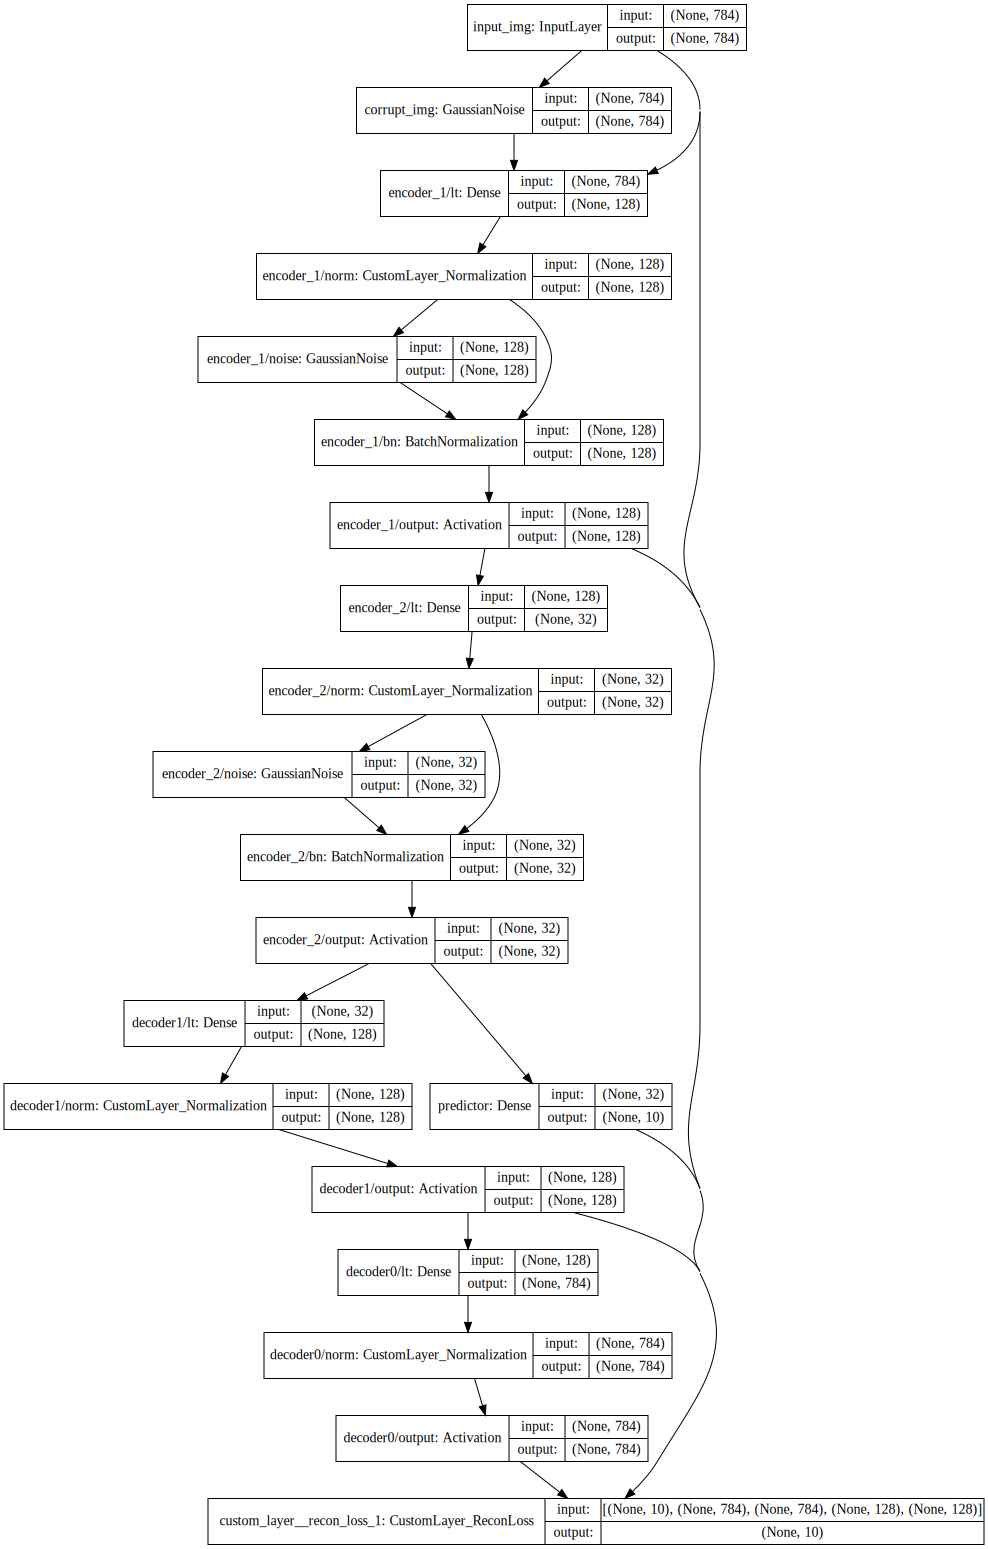

In [16]:
#ladder_custom.summary()
SVG(model_to_dot(ladder_custom,show_shapes=True).create(prog='dot',format='svg'))

## Compiling the model
In the compiler, supply the loss of the supervised part. The reconstruction loss is added automatically by the model due to the custom layer. 

In [17]:
ladder_custom.compile(optimizer='adadelta', loss='categorical_crossentropy')

In [18]:
ladder_custom.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 784)          0                                            
__________________________________________________________________________________________________
corrupt_img (GaussianNoise)     (None, 784)          0           input_img[0][0]                  
__________________________________________________________________________________________________
encoder_1/lt (Dense)            (None, 128)          100480      corrupt_img[0][0]                
                                                                 input_img[0][0]                  
__________________________________________________________________________________________________
encoder_1/norm (CustomLayer_Nor (None, 128)          0           encoder_1/lt[0][0]               
          

## Training the model
The model output y are the predicted labels. The loss function, however, containes contributions from the autoencoder. This is why the network is trained to reconstruct (DAE) and classify (clean encoder) simultaneously, even though this cannot be seen from the arguments of the fit below ( (train_x, train_y) looks like a supervised classification only).

In [19]:
infoLadder=ladder_custom.fit(x_train,y_train,
                epochs=10,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 22s 360us/step - loss: 1.7633 - val_loss: 1.3798
Epoch 2/10
60000/60000 [==============================] - 21s 356us/step - loss: 1.3501 - val_loss: 1.3130
Epoch 3/10
60000/60000 [==============================] - 21s 347us/step - loss: 1.2917 - val_loss: 1.2777
Epoch 4/10
60000/60000 [==============================] - 22s 373us/step - loss: 1.2612 - val_loss: 1.2564
Epoch 5/10
60000/60000 [==============================] - 21s 346us/step - loss: 1.2394 - val_loss: 1.2514
Epoch 6/10
60000/60000 [==============================] - 20s 340us/step - loss: 1.2235 - val_loss: 1.2395
Epoch 7/10
60000/60000 [==============================] - 20s 339us/step - loss: 1.2123 - val_loss: 1.2400
Epoch 8/10
60000/60000 [==============================] - 21s 344us/step - loss: 1.2035 - val_loss: 1.2347
Epoch 9/10
60000/60000 [==============================] - 20s 337us/step - loss: 1.1955 - val_

# Predicting and plotting

## encode and decode some digits


A layer is an object which has a well defined number of outputs. The input is not specified upon definition of the layer, but only upon "linking", i.e when the layer received a specific input. Only after linking, the weight tensor is defined and can then be trained. 

### predicting
After training the network we obtain a set of linked layers that already contain the trained weights. For example, "decoded[0]" stands for the output of the autoencoder which is linked to the input input_img, via a set of specific weights. We can now construct a new model that uses the weights for prediction. 

After constructing the model we can perform a prediction giving it x_test as an input, and obtaining the decoded image as an output. 


In [20]:
ladder_for_prediction = Model(input_img,[decoded[0],predicted_labels])
# Thenext two lines are for thesimple feed forawrd without the aouteconde
#ladder_for_prediction = Model(input_img,predicted_labels)
#encoder_output=ladder_for_prediction.predict(x_test)
[decoded_imgs,pred_labels] = ladder_for_prediction.predict(x_test)

Mean and std of decoded : 0.479, 0.183
Mean and std of original: 0.131, 0.301
Accuracy: 97.60 %


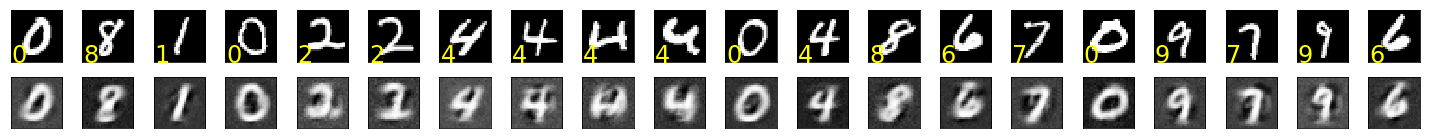

In [21]:
origmean,origstd=(np.mean(x_train)),np.mean(np.std(x_train,axis=1))
decodmean,decodstd=(np.mean(decoded_imgs)),np.mean(np.std(decoded_imgs,axis=1))
accuracy=np.mean(np.argmax(pred_labels,axis=1)==y_test_num)*100
print("Mean and std of decoded : %.3f, %.3f"%(decodmean,decodstd))
print("Mean and std of original: %.3f, %.3f"%(origmean,origstd))
print("Accuracy: %.2f %%"%accuracy)


n = 20  # how many digits we will display
plt.figure(figsize=(20, 2))
indices=np.arange(len(x_test))
np.random.shuffle(indices)
# pick randomly n images out of the test set, reconstruct and display them
for i,j in enumerate(indices[:n]):
    # display original
    ax = plt.subplot(2, n, i + 1)
    if np.argmax(pred_labels[j]) == np.argmax(y_test[j]) :
        ax.imshow(x_test[j].reshape(28, 28),cmap=plt.cm.gray)
        # display predicted label
        ax.text(0,28,np.argmax(pred_labels[j]),fontsize=24,color='yellow')
    else:
        ax.imshow(x_test[j].reshape(28, 28),cmap=plt.cm.gray_r)
        ax.text(0,28,np.argmax(pred_labels[j]),fontsize=24,color='red')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[j].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
plt.tight_layout()    

In [ ]:
# 

In [22]:
import pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)


In [25]:
analysis = {}
analysis['accuracy'] = accuracy
#analysis['training'] = infoLadder

In [26]:
save_obj(analysis,'ladder_sketch')

In [68]:
def savefile(filename):
    if theNotebook is None:
        print ("Run the cell starting with %%javascript ")
    else:
        os.system("jupyter nbconvert --to script %s --stdout > %s"%(theNotebook,filename))

In [67]:
theNotebook=None

In [71]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command)

<IPython.core.display.Javascript object>

In [72]:
savefile("gug.py")

In [27]:
ladder_custom.save('Model_ladder_sketch')